In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm, uniform
from scipy.special import softmax, erf
from scipy.optimize import minimize, root

from datetime import datetime

import matplotlib.pyplot as plt

# Andmed
Aasta 2023 juulist septembrini kestnud sõduri baaskursuse ajal kirja pandud spiooni- ning ka mittespiooni peerude toimumiskuupäevad ning -ajad. 

In [2]:
def make_df(filename):
    data = pd.read_csv(filename)
    
    data['kuupäev'] = data['kuupäev'].apply(lambda x: datetime.fromisoformat(x))
    data['m'] = data['kuupäev'].apply(lambda x: x.timetuple().tm_yday)
    data['m'] = data.groupby('m').ngroup()
    data['t'] = data['kuupäev'].apply(lambda x: (x - x.replace(hour=0, minute=0, second=0)).total_seconds() / 3600)
    
    return data.drop(columns=['kuupäev'])

In [3]:
df = make_df('andmed/spioonid.csv')
df.tail()

,m,t
114,29,21.970833
115,30,8.217500
116,30,8.343611
117,30,23.256667
118,31,22.762778


# Taust
Kirjeldatud meetod põhineb täielikult [Goulding et al.](http://www.cs.nott.ac.uk/~pszgss/goulding2016event_preprint.pdf)

Mittehomogeenset Poissoni protsessi kirjeldab ajast sõltuv intensiivsus $\lambda(t)$, see on ka näide loendavast protsessist, mida on võimalik defineerida kahe ajahetke $t_1$ ning $t_2$ vaheliste sündmuste arvu esinemise tõenäosuse kaudu
\begin{align*}
    &P(N(t_1, t_2) = c) = \frac{ \Lambda(t_1, t_2)^c}{c!} e^{- \Lambda(t_1, t_2)} \\
    \text{kus} \quad &\Lambda(t_1, t_2) = \int_{t_1}^{t_2} \lambda(t) dt
\end{align*}
Intensiivsusfunktsiooni kaudu on võimalik avaldada jaotusfunktsioon $F^s(t)$, mis kirjeldab oodatavat aega hetkest $s$ kuni uue sündmuse toimumiseni
\begin{equation*}
    F^s(t) = 1 - e^{\Lambda(s, s + t)}
\end{equation*}
Jaotusfunktsiooni on võimalik kasutada ennustamiseks, lisaks on selle põhjal võimalik leida sündmusrea $\textbf{t}_i = \langle t_{i0} , t_{i1} , \dots , t_{ij} \rangle$ ühisjaotuse tihedus $f(\textbf{t}_i)$, mis kirjeldab tõenäosust, et rida pärineb sellelt protsessilt.
\begin{equation*}
    f(\textbf{t}_i | \tau) = e^{- \Lambda (0 , \tau) } \prod_{j = 1}^n \lambda (t_{ij})
\end{equation*}
kus $\tau$ tähistab protsessi indekshulga vähimat ülemist tõket.

# Mudel
Formaalselt võib eelnevat andmestikku kirjeldada sündmusridade hulgana $\mathcal{T} = \{ \textbf{t}_1 , \textbf{t}_2 , \dots , \textbf{t}_m \}$, mille realisatsioonid $\textbf{t}_i = \langle t_{i0} , t_{i1} , \dots , t_{ij} \rangle$ pärinevalt mingilt mittehomogeense Poissoni liitprotsessi alamprotsessilt.

Andmestikku modelleerime $Z$ alamprotsessist koosneva MHPP liitprotsessina, mille alamprotsesside intesiivsused on $K$ kaalutud normaaljaotustiheduste summad 
\begin{align*}
    &\lambda_z(t) = \sum_{k = 1}^K a_{z k} B_k(t) \\
    \text{kus} \quad &B_k(t) = \frac{1}{\sigma \sqrt{2 \pi}} \exp \left( - \frac{(t - \mu_k)^2}{2 \sigma^2} \right) \\
    \text{ning} \quad &\mu_k = \frac{(k - 1) \tau}{K - 1} , \qquad \sigma_k = \frac{\tau}{k} 
\end{align*}

In [4]:
K = 20  # number of gaussian variables
m = df['m'].nunique()  # number of event series
Z = 5  # number of parent processes

k = np.arange(1, K + 1)
tau = df['t'].max()
locs = ((k - 1) * tau) / (K - 1)  # means evenly spread accros time domain
scales = tau / k  # standard deviations

In [5]:
def rate(x, weights):
    return np.sum(weights * norm.pdf(x, loc=locs, scale=scales))


def joint_pdf(xs, weights):
    integral = np.sum(weights * norm.cdf(tau, loc=locs, scale=scales))
    return np.exp(-integral) * np.prod([rate(x, weights) for x in xs])

## Parameetrite sobitamine
Toodud ehitusklotside põhjal taandub mudeli loomine kaalude $a_{zk}$ leidmisele. Kaalude leidmiseks vaatame parameetrite suhtes mudeli tõepära funktsiooni. Igale alamprotsessile $N_z(t)$ seame vastavusse segandumis tõenäosuse $p_z$, mis kirjedab võimalust, et mingi sündmusterida hulgas $\mathcal{T}$ pärineb sellelt alamprotsessilt. Eelnevast lähtudes on kogu mudeli tõepära funktsioon
\begin{equation*}
    \mathcal{L}(\theta | \mathcal{T}) = \prod_{i = 1}^m \sum_{z = 1}^Z p_z f_z(\textbf{t}_i | \tau)
\end{equation*}
kus $\theta = \langle \lambda_1 , \lambda_2 , \dots , \lambda_Z \rangle$.
Järgnevalt leiame mudeli kaalud iteratiivselt, kasuted EM (expectation maximization) meetodit. Alustades algsete parameetritega $\theta^0$ (siin tähistame $r$-indat iteratsioonisammu kujul $\theta^r$).

In [6]:
def negative_log_likelihood(weights, weights_shape, mix_probs, orig_probs, orig_probs_shape, data):
    weights = weights.reshape(weights_shape)
    gp = data.groupby('m')['t']
    
    likelihood = 0
    for i, z in np.ndindex(orig_probs_shape):
        t_vec = gp.get_group(i)
        likelihood += orig_probs[(i, z)] * np.log(mix_probs[z] * joint_pdf(t_vec, weights[z]))
    
    return -likelihood  # negate for maximization using 'scipy.optimize.minimize'

### Ooteväärtuse samm
Antud parameetrivektori $\theta^r$ korral leiame iga alamprotsessi jaoks tõenäosused, et sündmuste rida $\textbf{t}_i$ pärineb sellelt alamprotsessilt
\begin{equation*}
    p_{iz}^r = \frac{ e^{- \Lambda_z (0 , \tau) } \prod_{j = 1}^n \lambda_z (t_{ij}) }{ \sum_{q = 1}^{Z} e^{- \Lambda_q (0 , \tau)} \prod_{j = 1}^n \lambda_q (t_{ij}) }
\end{equation*}

In [7]:
def expectation_step(data, orig_probs_shape, weights):
    gp = data.groupby('m')['t']
    orig_probs = np.zeros(orig_probs_shape)
    
    for i, z in np.ndindex(orig_probs_shape):
        t_vec = gp.get_group(i)
        
        numerator = joint_pdf(t_vec, weights[z])
        denominator = np.sum([joint_pdf(t_vec, weights[q]) for q in range(Z)])
        
        orig_probs[(i, z)] = numerator / denominator
    
    return orig_probs

### Maksimeerimise samm
Saadud pärinemistõenäosustega leiame uued parameetrite lähendid $\theta^{r + 1}$ suurima logaritm tõepära meetodil
\begin{equation*}
    \theta^{r + 1} = \underset{\theta}{\arg \max} \left[ \sum_{i = 1}^m \sum_{z = 1}^Z p_{iz} \ln \left( p_z e^{- \Lambda_z (0 , \tau) } \prod_{j = 1}^n \lambda_z (t_{ij}) \right) \right]
\end{equation*}
pramaeetrid leiame numbriliselt.

Järgmised hinnangud segandumistõenäosustele leiame lihtsa aritmeetilise keskmisena pärinemistõenäosustest
\begin{equation*}
    p_z^{r + 1} = \frac{1}{n} \sum_{i = 1}^m p_{iz}^r
\end{equation*}

In [8]:
def maximisation_step(data, weights, mix_probs, orig_probs):
    weights_shape = weights.shape
    theta = weights.flatten()
    
    args = (weights_shape, mix_probs, orig_probs, orig_probs.shape, data)
    bounds = ((0, float('inf')) for _ in theta)
    optimize_result = minimize(negative_log_likelihood, theta, args=args, bounds=bounds)
    
    weights = optimize_result['x'].reshape(weights_shape)
    mix_probs = orig_probs.mean(axis=0)
    
    return weights, mix_probs, optimize_result

EM meetodi iteratsioonisamme kordame kuni kindla sammude arvuni või koondumiseni

In [9]:
def em(data, initial_weights, num_series, num_subprocess, max_steps=10, diff_threshold=1e-5, verbose=False):
    orig_probs = softmax(np.zeros((num_series, num_subprocess), dtype=np.longdouble))
    mixing_probs = np.mean(orig_probs, axis=0)
    
    step = 0
    diff_norm = diff_threshold
    while step <= max_steps and diff_norm >= diff_threshold:
        # expectation step
        orig_probs = expectation_step(data, orig_probs.shape, initial_weights)
        
        # maximisation step
        weights, mixing_probs, _ = maximisation_step(data, initial_weights, mixing_probs, orig_probs)
        
        # diff
        if verbose:
            diff = weights - initial_weights
            diff_norm = np.linalg.norm(diff, ord=2)
            print(f'step={step}, diff_2norm={diff_norm}')
        
        # iteration step
        initial_weights = weights
        step += 1
        
    return initial_weights

In [10]:
model_weights = em(df, uniform.rvs(0, 1, size=(Z, K)), m, Z, max_steps=25, verbose=True)
# pd.DataFrame(weights.T).to_csv(f'kaalud_z{Z}_k{K}.csv')

step=0, diff_2norm=4.980160056292062
step=1, diff_2norm=1.0948689248321484
step=2, diff_2norm=0.9050704154967901
step=3, diff_2norm=0.5013219279710088
step=4, diff_2norm=0.38908989165076086
step=5, diff_2norm=0.3637426075906299
step=6, diff_2norm=0.32181698624519833
step=7, diff_2norm=0.34268222337062787
step=8, diff_2norm=0.33198920028298384
step=9, diff_2norm=0.21784385010453386
step=10, diff_2norm=0.5729720140899166
step=11, diff_2norm=0.7743149842393792
step=12, diff_2norm=0.7306818528726687
step=13, diff_2norm=0.49594075384796554
step=14, diff_2norm=0.29015405576680636
step=15, diff_2norm=0.1503912917045766
step=16, diff_2norm=0.04749921731144392
step=17, diff_2norm=0.024230490878456478
step=18, diff_2norm=0.0015043452776706493
step=19, diff_2norm=0.08301779288032546
step=20, diff_2norm=0.07423529228156547
step=21, diff_2norm=0.06437645042018823
step=22, diff_2norm=0.012673818418388121
step=23, diff_2norm=0.07272046690608605
step=24, diff_2norm=0.054298555208534854
step=25, diff_2

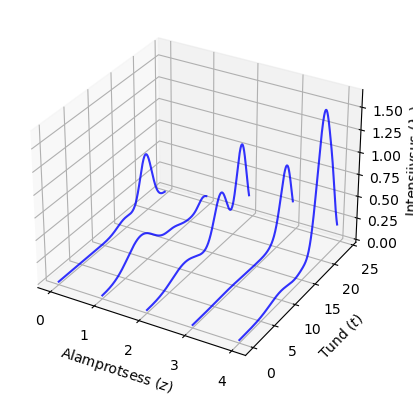

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for sub_process in range(Z):
    time = np.linspace(0, 24, 500)
    sub_process_rate = [rate(t, model_weights[sub_process]) for t in time]
    
    ax.plot(time, sub_process_rate, zs=sub_process, zdir='x', color='b', alpha=0.8)

ax.set_xlabel('Alamprotsess $(z)$')
ax.set_ylabel('Tund $(t)$')
ax.set_zlabel('Intensiivsus $(\\lambda_z)$')

fig.savefig(f'joonised/mudel_z{Z}_k{K}.png', dpi=100)

## Mudeli kasutamine
Ennustamaks järgmise sündmuse toimumishetke sündmusreas $\textbf{t}$, peame kõigepealt nimetatud sündmusrea seostama mudeli mingi alamprotsessiga. Soovitud alamprotsessi $z$ valime suurima tõepära meetodiga
\begin{equation*}
    z = \underset{z \in \{ 1 , 2 , \dots , Z \} }{\arg \max} f_z(\textbf{t} | \tau)
\end{equation*}

In [12]:
test_df = make_df('andmed/spioonid_lisa.csv')
test_times = test_df[test_df['m'] == 0]['t']

sub_process = np.argmax([joint_pdf(test_times, model_weights[sub_process]) for sub_process in range(Z)])

### Aeg järgmise sündmuseni
Kui oleme leidnud võimalik sündmusrea tootnud alamprotsessi, ennustame aega järgmise sündmuse toimumiseni $\eta$ alamprotsessi jaotuse mediaanina
\begin{align*}
    F_z^s(\eta) = 1 - e^{\Lambda_z(s , s + \eta)} &= \frac{1}{2} \\
    \Lambda_z(s , s + \eta) - \ln 2 &= 0
\end{align*}

Tehes asendused ning integreerimse jõuame võrrandini
\begin{equation*}
    \sum_{k = 1}^K \frac{a_{zk}}{2} \left[ \text{erf} \left( \frac{s + \eta - \mu_k}{\sqrt{2} \sigma_k} \right) - \text{erf} \left( \frac{s - \mu_k}{\sqrt{2} \sigma_k} \right) \right] - \ln 2 = 0
\end{equation*}
Kuna kõik muutujad peale $\eta$ on teada, saame lähendi leida kiiresti kasutades numbrilisi meetodeid.

In [13]:
def cdf_expression(eta, from_t, process_weights, quantile=0.5):
    q_log = np.log(1 / quantile)
    scaled_weights = process_weights / 2
    numerator = from_t - locs
    denominator = np.sqrt(2) * scales
    return np.sum(scaled_weights * (erf((numerator + eta) / denominator) - erf(numerator / denominator))) - q_log

In [14]:
from_time = 16.45
root_result = root(cdf_expression, np.array([0]), args=(from_time, model_weights[sub_process]))
wait_time = root_result['x']

print(f'praegune aeg: {from_time}\nennustatud ooteaeg: {wait_time}')

praegune aeg: 16.45
ennustatud ooteaeg: [1.23697374]
